In [215]:
import pandas as pd
import numpy as np
df=pd.read_csv("iris(1).csv")
print(df.shape)

(150, 5)


,sepal_length,sepal_width,petal_length,petal_width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


In [179]:
import patsy
response,predictors=patsy.dmatrices('variety~sepal_length+sepal_width+petal_length+petal_width+0',data=df)
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(predictors,response,random_state=0)
print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

In [181]:
import torch
y=torch.from_numpy(y_train)
X=torch.from_numpy(X_train)
X = X.to(torch.float32)
y = y.to(torch.float32)
test_y=torch.from_numpy(y_test)
test_X=torch.from_numpy(X_test)
test_X = test_X.to(torch.float32)
test_y = test_y.to(torch.float32)

In [198]:
import torch.nn as nn
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.fc1=nn.Linear(4,400)
        self.fc11=nn.ReLU()
        self.fc2=nn.Linear(400,3)
    def forward(self,x):
        out=self.fc1(x)
        out=self.fc11(out)
        out=self.fc2(out)
        return(out)
mynet=net()
criterion=nn.MSELoss()
optimizer=torch.optim.SGD(mynet.parameters(),lr=0.001)

In [201]:
for epoch in range(1000):
    outputs=mynet(X)
    loss=criterion(outputs,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [235]:
_,predicted = torch.max(mynet(test_X), 1)
classes=['Setosa', 'Versicolor', 'Virginica']
class_correct=list(0. for i in range(3))
class_total=list(0. for i in range(3))
labels=torch.max(test_y,1)[1]
c=(predicted==labels)
for i in range(len(c)):
    label=labels[i]
    class_correct[label]+=c[i].item()
    class_total[label]+=1
for i in range(3):
    print('Accuracy of %5s : %.1f %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of Setosa : 100.0 %
Accuracy of Versicolor : 75.0 %
Accuracy of Virginica : 100.0 %


In [236]:
correct=0
correct += (predicted == torch.max(test_y,1)[1]).sum().item()
print('Accuracy of All : %.3f %%' % (100*correct/sum(class_total)))

Accuracy of All : 89.474 %


第二问

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
df=pd.read_csv("housing_renamed.csv")
print(df.shape)
df.head()
df.dropna(inplace=True)
list(df.columns)

(2626, 13)


['neighborhood',
 'type',
 'units',
 'year_built',
 'sq_ft',
 'income',
 'income_per_sq_ft',
 'expense',
 'expense_per_sq_ft',
 'net_income',
 'value',
 'value_per_sq_ft',
 'boro']

In [5]:
from sklearn.preprocessing import MinMaxScaler
ss=MinMaxScaler()
import patsy
response,predictors=patsy.dmatrices('value_per_sq_ft~neighborhood+type+units+year_built+sq_ft+income+income_per_sq_ft+expense+expense_per_sq_ft+net_income+value+boro+0',data=df)
# response=ss.fit_transform(response)
predictors=ss.fit_transform(predictors)
from sklearn.model_selection import KFold,cross_val_score
kf=KFold(n_splits=3)
train_size=1897
batch_size=300
iter_per_epoch=max(train_size//batch_size,1)
import torch.nn as nn
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.fc1=nn.Linear(164,2000)
        self.fc11=nn.ReLU()
        self.fc2=nn.Linear(2000,2000)
        self.fc22=nn.ReLU()
        self.fc3=nn.Linear(2000,1)
    def forward(self,x):
        out=self.fc1(x)
        out=self.fc11(out)
        out=self.fc2(out)
        out=self.fc22(out)
        out=self.fc3(out)
        # out=F.softmax(out)
        return(out)
loss_list=[[]]
test_loss=[[]]
import torch
device=torch.device('cuda')
ii=0
for train,test in kf.split(predictors):
    ii+=1
    X_train,X_test=predictors[train],predictors[test]
    y_train,y_test=response[train],response[test]
    y=torch.from_numpy(y_train)
    X=torch.from_numpy(X_train)
    X = X.to(torch.float32).to(device)
    y = y.to(torch.float32).to(device)
    test_y=torch.from_numpy(y_test)
    test_X=torch.from_numpy(X_test)
    test_X = test_X.to(torch.float32).to(device)
    test_y = test_y.to(torch.float32).to(device)
    train_size=X_train.shape[0]
    batch_size=300 
    mynet=net().to(device)
    criterion=nn.MSELoss()
    optimizer=torch.optim.Adam(mynet.parameters(),lr=0.001)
    tmploss_list=[]
    tmptest_loss=[]
    for i in range(2000):
        batch_mask=np.random.choice(train_size,batch_size)
        X_batch=X[batch_mask]
        y_batch=y[batch_mask]
        outputs=mynet(X_batch)
        loss=criterion(outputs,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tmploss_list.append(loss.item())
        if i%iter_per_epoch==0:
            tmptest_loss.append(criterion(mynet(test_X),test_y).item())
    loss_list.append(tmploss_list)
    test_loss.append(tmptest_loss)
    print(ii)

1
2
3


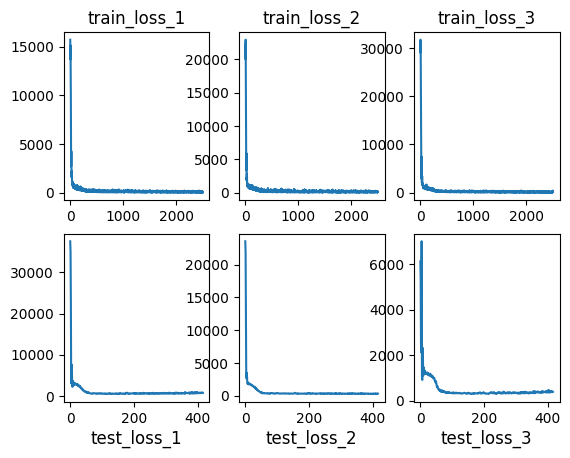

In [262]:
picdf1=pd.DataFrame(loss_list[1:]+test_loss[1:]).T
import matplotlib.pyplot as plt
fig=plt.figure()
axes1=fig.add_subplot(2,3,1)
axes1.set_title('train_loss_1')
axes2=fig.add_subplot(2,3,2)
axes2.set_title('train_loss_2')
axes3=fig.add_subplot(2,3,3)
axes3.set_title('train_loss_3')
axes4=fig.add_subplot(2,3,4)
axes4.set_title('test_loss_1',y=-0.3)
axes5=fig.add_subplot(2,3,5)
axes5.set_title('test_loss_2',y=-0.3)
axes6=fig.add_subplot(2,3,6)
axes6.set_title('test_loss_3',y=-0.3)
axes1.plot(picdf1[0])
axes2.plot(picdf1[1])
axes3.plot(picdf1[2])
axes4.plot(picdf1[3])
axes5.plot(picdf1[4])
axes6.plot(picdf1[5])

In [277]:
last_loss1=[i[-1] for i in loss_list[1:]]+[i[-1] for i in test_loss[1:]]
last_loss1

[23.981735229492188,
 101.7363052368164,
 186.9088592529297,
 703.072021484375,
 300.686279296875,
 389.1449279785156]

第二个模型

In [119]:
from sklearn.preprocessing import MinMaxScaler
ss=MinMaxScaler()
import patsy
response,predictors=patsy.dmatrices('value_per_sq_ft~neighborhood+type+units+year_built+sq_ft+income+income_per_sq_ft+expense+expense_per_sq_ft+net_income+value+boro+0',data=df)
# response=ss.fit_transform(response)
predictors=ss.fit_transform(predictors)
from sklearn.model_selection import KFold,cross_val_score
kf=KFold(n_splits=3)
train_size=1897
batch_size=300
iter_per_epoch=max(train_size//batch_size,1)
import torch.nn as nn
# import torch.nn as nnb
import torch.nn.functional as F
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.fc1=nn.Linear(164,700)
        self.fc11=nn.ReLU()
        self.fc2=nn.Linear(700,1000)
        self.fc22=nn.ReLU()
        self.fc3=nn.Linear(1000,700)
        self.fc33=nn.ReLU()
        # self.fc4=nn.Linear(1000,1500)
        # self.fc44=nn.ReLU()
        # self.fc5=nn.Linear(1500,1000)
        # self.fc55=nn.ReLU()
        # self.fc6=nn.Linear(700,700)
        # self.fc66=nn.ReLU()
        # self.fc7=nn.Linear(700,700)
        # self.fc77=nn.ReLU()
        # self.fc8=nn.Linear(700,700)
        # self.fc88=nn.ReLU()
        self.fc9=nn.Linear(700,1)
        
    def forward(self,x):
        out=self.fc1(x)
        out=self.fc11(out)
        out=self.fc2(out)
        out=self.fc22(out)
        out=self.fc3(out)
        out=self.fc33(out)
        # out=self.fc4(out)
        # out=self.fc44(out)
        # out=self.fc5(out)
        # out=self.fc55(out)
        # out=self.fc6(out)
        # out=self.fc66(out)
        # out=self.fc7(out)
        # out=self.fc77(out)
        # out=self.fc8(out)
        # out=self.fc88(out)
        out=self.fc9(out)
        return(out)
loss_list=[[]]
test_loss=[[]]
import torch
device=torch.device('cuda')
ii=0
for train,test in kf.split(predictors):
    ii+=1
    X_train,X_test=predictors[train],predictors[test]
    y_train,y_test=response[train],response[test]
    y=torch.from_numpy(y_train)
    X=torch.from_numpy(X_train)
    X = X.to(torch.float32).to(device)
    y = y.to(torch.float32).to(device)
    test_y=torch.from_numpy(y_test)
    test_X=torch.from_numpy(X_test)
    test_X = test_X.to(torch.float32).to(device)
    test_y = test_y.to(torch.float32).to(device)
    train_size=X_train.shape[0]
    batch_size=300 
    mynet=net().to(device)
    criterion=nn.MSELoss()
    optimizer=torch.optim.Adam(mynet.parameters(),lr=0.001)
    tmploss_list=[]
    tmptest_loss=[]
    for i in range(2500):
        batch_mask=np.random.choice(train_size,batch_size)
        X_batch=X[batch_mask]
        y_batch=y[batch_mask]
        outputs=mynet(X_batch)
        loss=criterion(outputs,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tmploss_list.append(loss.item())
        if i%iter_per_epoch==0:
            tmptest_loss.append(criterion(mynet(test_X),test_y).item())
    loss_list.append(tmploss_list)
    test_loss.append(tmptest_loss)
    print(ii)

1
2
3


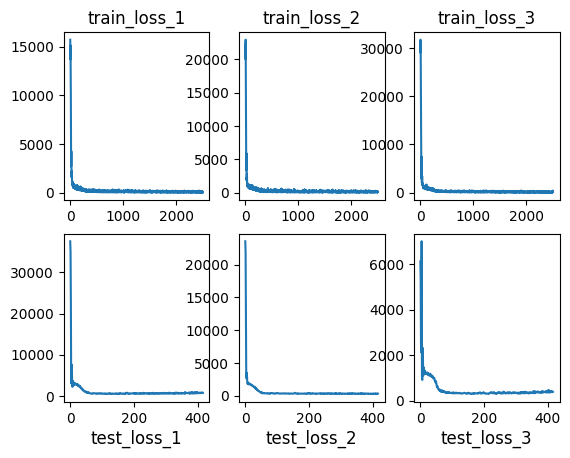

In [ ]:
picdf2=pd.DataFrame(loss_list[1:]+test_loss[1:]).T
import matplotlib.pyplot as plt
fig=plt.figure()
axes1=fig.add_subplot(2,3,1)
axes1.set_title('train_loss_1')
axes2=fig.add_subplot(2,3,2)
axes2.set_title('train_loss_2')
axes3=fig.add_subplot(2,3,3)
axes3.set_title('train_loss_3')
axes4=fig.add_subplot(2,3,4)
axes4.set_title('test_loss_1',y=-0.3)
axes5=fig.add_subplot(2,3,5)
axes5.set_title('test_loss_2',y=-0.3)
axes6=fig.add_subplot(2,3,6)
axes6.set_title('test_loss_3',y=-0.3)
axes1.plot(picdf2[0])
axes2.plot(picdf2[1])
axes3.plot(picdf2[2])
axes4.plot(picdf2[3])
axes5.plot(picdf2[4])
axes6.plot(picdf2[5])

In [ ]:
last_loss2=[i[-1] for i in loss_list[1:]]+[i[-1] for i in test_loss[1:]]
last_loss2

[23.981735229492188,
 101.7363052368164,
 186.9088592529297,
 703.072021484375,
 300.686279296875,
 389.1449279785156]

In [120]:
test_loss[3][-1]

389.1449279785156

In [122]:
loss_list[1][-1]

23.981735229492188

In [33]:
print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)
train_size=1897
batch_size=300
iter_per_epoch=max(train_size//batch_size,1)

(1897, 1)
(1897, 164)
(633, 1)
(633, 164)


In [9]:
import torch
device=torch.device('cuda')
y=torch.from_numpy(y_train)
X=torch.from_numpy(X_train)
X = X.to(torch.float32).to(device)
y = y.to(torch.float32).to(device)
test_y=torch.from_numpy(y_test)
test_X=torch.from_numpy(X_test)
test_X = test_X.to(torch.float32).to(device)
test_y = test_y.to(torch.float32).to(device)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [35]:
import torch.nn as nn
import torch.nn.functional as F
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.fc1=nn.Linear(164,2000)
        self.fc11=nn.ReLU()
        self.fc2=nn.Linear(2000,2000)
        self.fc22=nn.ReLU()
        self.fc3=nn.Linear(2000,1)
    def forward(self,x):
        out=self.fc1(x)
        out=self.fc11(out)
        out=self.fc2(out)
        out=self.fc22(out)
        out=self.fc3(out)
        # out=F.softmax(out)
        return(out)
mynet=net().to(device)


In [115]:
import torch.nn as nn
import torch.nn.functional as F
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.fc1=nn.Linear(164,2400)
        self.fc11=nn.ReLU()
        self.fc2=nn.Linear(2400,2400)
        self.fc22=nn.ReLU()
        self.fc3=nn.Linear(2400,1)
    def forward(self,x):
        out=self.fc1(x)
        out=self.fc11(out)
        out=self.fc2(out)
        out=self.fc22(out)
        out=self.fc3(out)
        # out=F.softmax(out)
        return(out)
mynet=net().to(device)


In [216]:
cin=mynet(X)
nn.Softmax(cin)

C:\Users\zyc\AppData\Local\Temp\ipykernel_11992\718216199.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out=self.fc55(out)


Softmax(
  dim=tensor([[1.],
          [1.],
          [1.],
          ...,
          [1.],
          [1.],
          [1.]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
)

In [8]:
import torch.nn as nn
import torch.nn.functional as F
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.fc1=nn.Linear(164,700)
        self.fc11=nn.ReLU()
        self.fc2=nn.Linear(700,700)
        self.fc22=nn.ReLU()
        self.fc3=nn.Linear(700,700)
        self.fc33=nn.ReLU()
        self.fc4=nn.Linear(700,700)
        self.fc44=nn.ReLU()
        self.fc5=nn.Linear(700,700)
        self.fc55=nn.ReLU()
        self.fc6=nn.Linear(700,700)
        self.fc66=nn.ReLU()
        self.fc7=nn.Linear(700,700)
        self.fc77=nn.ReLU()
        self.fc8=nn.Linear(700,700)
        self.fc88=nn.ReLU()
        self.fc9=nn.Linear(700,1)
        
    def forward(self,x):
        out=self.fc1(x)
        out=self.fc11(out)
        out=self.fc2(out)
        out=self.fc22(out)
        out=self.fc3(out)
        out=self.fc33(out)
        out=self.fc4(out)
        out=self.fc44(out)
        out=self.fc5(out)
        out=self.fc55(out)
        out=self.fc6(out)
        out=self.fc66(out)
        out=self.fc7(out)
        out=self.fc77(out)
        out=self.fc8(out)
        out=self.fc88(out)
        out=self.fc9(out)
        return(out)
mynet=net().to(device)


In [105]:
import torch.nn as nn
import torch.nn.functional as F
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.fc1=nn.Linear(164,1500)
        self.fc11=nn.ReLU()
        self.fc2=nn.Linear(1500,1000)
        self.fc22=nn.ReLU()
        self.fc3=nn.Linear(1000,700)
        self.fc33=nn.ReLU()
        # self.fc4=nn.Linear(1400,1500)
        # self.fc44=nn.ReLU()
        # self.fc5=nn.Linear(1500,1000)
        # self.fc55=nn.ReLU()
        # self.fc6=nn.Linear(700,700)
        # self.fc66=nn.ReLU()
        # self.fc7=nn.Linear(700,700)
        # self.fc77=nn.ReLU()
        # self.fc8=nn.Linear(700,700)
        # self.fc88=nn.ReLU()
        self.fc9=nn.Linear(700,1)
        
    def forward(self,x):
        out=self.fc1(x)
        out=self.fc11(out)
        out=self.fc2(out)
        out=self.fc22(out)
        out=self.fc3(out)
        out=self.fc33(out)
        # out=self.fc4(out)
        # out=self.fc44(out)
        # out=self.fc5(out)
        # out=self.fc55(out)
        # out=self.fc6(out)
        # out=self.fc66(out)
        # out=self.fc7(out)
        # out=self.fc77(out)
        # out=self.fc8(out)
        # out=self.fc88(out)
        out=self.fc9(out)
        return(out)
mynet=net().to(device)


In [106]:
# mynet(X)

In [116]:
# criterion=nn.SmoothL1Loss()
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(mynet.parameters(),lr=0.001)

In [117]:
loss_list=[]
test_loss=[]
for i in range(2000):
    batch_mask=np.random.choice(train_size,batch_size)
    X_batch=X[batch_mask]
    y_batch=y[batch_mask]
    outputs=mynet(X_batch)
    loss=criterion(outputs,y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    if i%iter_per_epoch==0:
        test_loss.append(criterion(mynet(test_X),test_y).item())

In [109]:
criterion(mynet(X),y)

tensor(92.2432, device='cuda:0', grad_fn=<MseLossBackward0>)

In [118]:
sum(loss_list[-100:])/100

127.65276767730712

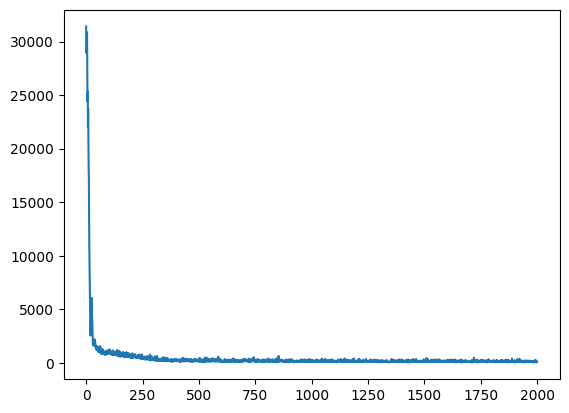

In [63]:
import matplotlib.pyplot as plt
plt.plot(loss_list)

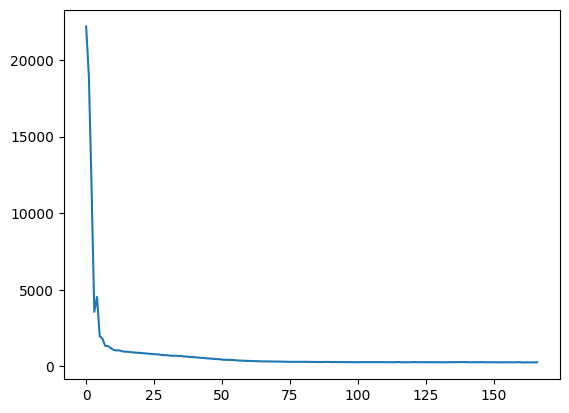

In [41]:
import matplotlib.pyplot as plt
plt.plot(test_loss)

In [42]:
min(test_loss)

245.06346130371094

In [116]:
mynet(X)

tensor([[218.5006],
        [110.4129],
        [248.7522],
        ...,
        [165.5020],
        [142.4770],
        [ 90.2684]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [117]:
y

tensor([[225.2900],
        [112.5300],
        [254.0800],
        ...,
        [171.6400],
        [146.0300],
        [ 91.2300]], device='cuda:0')

In [118]:
min(loss_list)

1.6900272369384766

In [127]:
mynet(test_X)


tensor([[178.3064],
        [103.9309],
        [ 71.9001],
        [118.8804],
        [ 52.3011],
        [ 84.9805],
        [211.5675],
        [ 60.3873],
        [248.3608],
        [ 64.1940],
        [ 89.7607],
        [217.0122],
        [ 90.2988],
        [ 54.5571],
        [ 73.6015],
        [252.3165],
        [217.1869],
        [163.8883],
        [ 68.7505],
        [174.7358],
        [206.5154],
        [106.1586],
        [ 75.8244],
        [188.5768],
        [131.5389],
        [ 75.3446],
        [188.8250],
        [178.5805],
        [215.9977],
        [ 55.0162],
        [ 80.9481],
        [176.6434],
        [ 85.9337],
        [173.9392],
        [ 88.2381],
        [243.1702],
        [ 81.2886],
        [ 66.4790],
        [159.0235],
        [209.9034],
        [179.2996],
        [ 53.4280],
        [ 90.9549],
        [ 85.1420],
        [ 70.9587],
        [157.9586],
        [201.5415],
        [ 84.6570],
        [174.0234],
        [199.4026],


In [121]:
test_y

tensor([[177.3400],
        [ 98.1700],
        [ 72.3500],
        [117.5300],
        [ 52.4200],
        [ 88.9900],
        [213.6200],
        [ 57.6000],
        [250.0400],
        [ 68.7200],
        [ 98.4700],
        [222.0000],
        [ 89.9000],
        [ 79.5400],
        [ 71.7700],
        [250.3700],
        [216.7400],
        [169.2600],
        [ 65.3400],
        [166.6600],
        [205.4100],
        [105.8200],
        [ 72.9500],
        [209.2900],
        [130.9200],
        [ 72.3500],
        [179.7200],
        [181.8300],
        [213.9000],
        [ 54.1200],
        [ 79.5000],
        [152.7700],
        [ 81.7300],
        [163.0000],
        [105.6300],
        [242.9400],
        [ 80.5900],
        [ 65.1000],
        [163.1600],
        [215.6100],
        [180.0600],
        [ 57.7300],
        [ 98.6900],
        [ 86.5200],
        [ 65.9500],
        [163.2100],
        [173.9700],
        [ 67.1900],
        [180.3900],
        [197.7800],
